In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


# Cargar datos
df = pd.read_csv('Mall_Customers.csv')

# Limpiar y convertir 'Genre' a numérico
df['Gender'] = df['Gender'].str.strip()  # Eliminar espacios en blanco al principio y al final
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   CustomerID              200 non-null    int64
 1   Gender                  200 non-null    int64
 2   Age                     200 non-null    int64
 3   Annual Income (k$)      200 non-null    int64
 4   Spending Score (1-100)  200 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB
None
       CustomerID      Gender         Age  Annual Income (k$)  \
count  200.000000  200.000000  200.000000          200.000000   
mean   100.500000    0.560000   38.850000           60.560000   
std     57.879185    0.497633   13.969007           26.264721   
min      1.000000    0.000000   18.000000           15.000000   
25%     50.750000    0.000000   28.750000           41.500000   
50%    100.500000    1.000000   36.000000           61.500000   
75%    150.250000    1.000000   49.000000

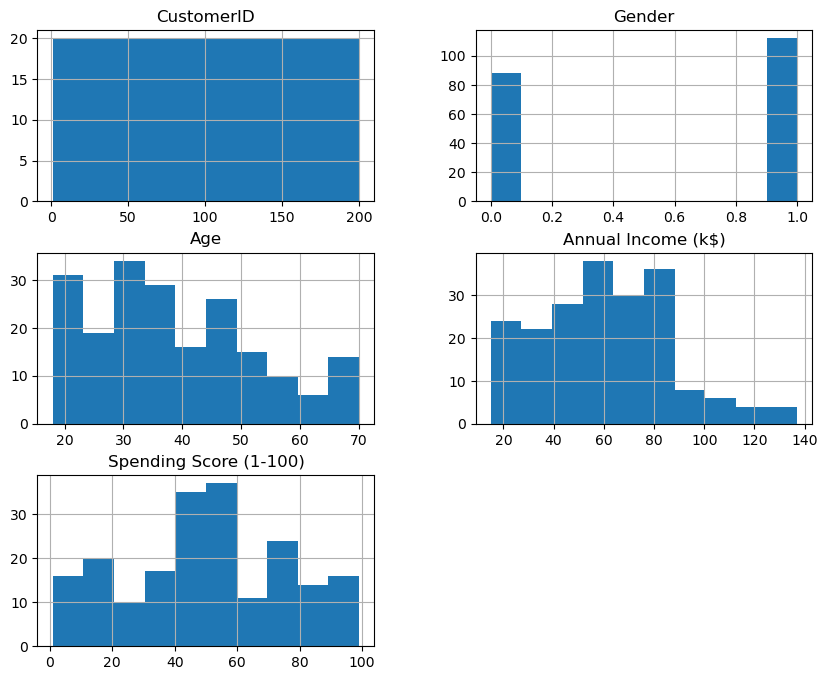

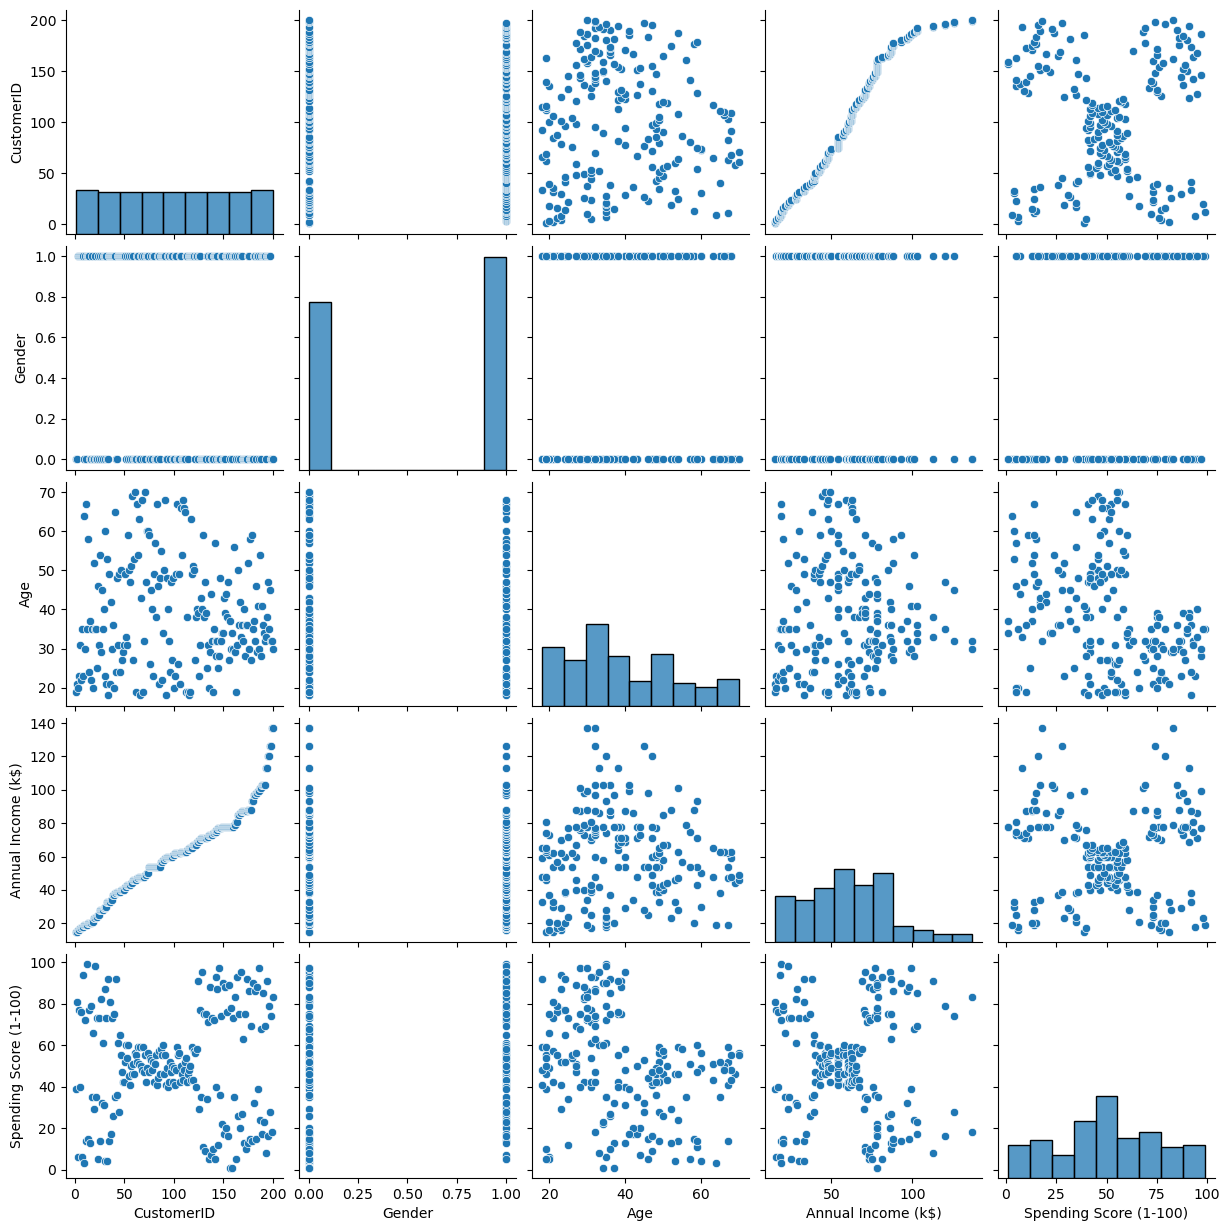

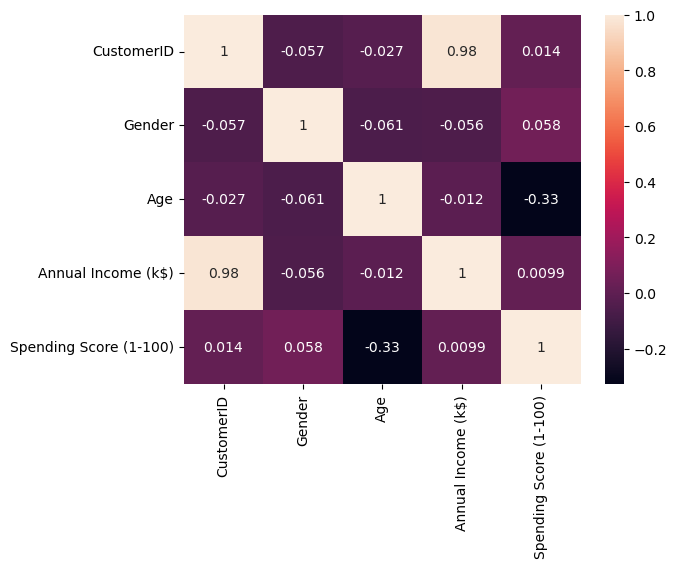

In [2]:
# Información general del dataset
print(df.info())

# Estadísticas descriptivas
print(df.describe())

# Visualización de la distribución de variables numéricas
df.hist(figsize=(10, 8))
plt.show()

# Visualización de la relación entre variables
sns.pairplot(df)
plt.show()

# Análisis de correlación
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

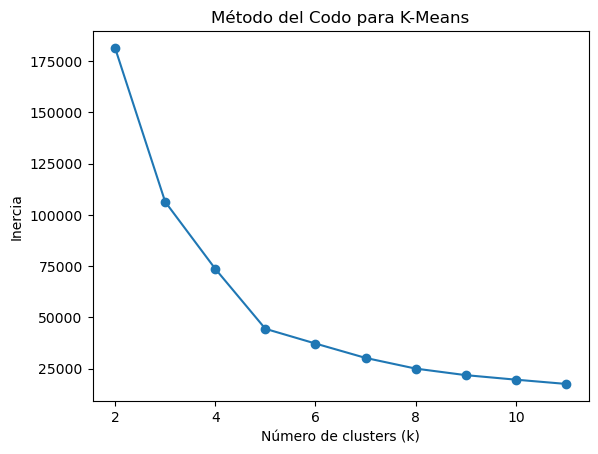

In [3]:
# Preprocesamiento (el resto del preprocesamiento)
df = df.drop('CustomerID', axis=1)  # Eliminar 'CustomerID' DESPUÉS de la correlación si no se quiere incluir

# Selección de características (prueba diferentes combinaciones)
selected_features = ['Annual Income (k$)', 'Spending Score (1-100)']  # Ejemplo
df_selected = df[selected_features]

# Definir K_range ANTES del bucle
K_range = range(2, 12)  # O el rango que desees

# Método del codo (sin escalar)
inertia = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(df_selected)
    inertia.append(kmeans.inertia_)


plt.plot(K_range, inertia, marker='o') # Ahora K_range está definido.
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.show()

# Escalado (después del codo - prueba diferentes escaladores)
scaler = StandardScaler() # O MinMaxScaler()
df_scaled = scaler.fit_transform(df_selected)

Silhouette Score: 0.5546571631111091
Calinski-Harabasz Index: 248.64932001536357
Davies-Bouldin Index: 0.5722356162263352


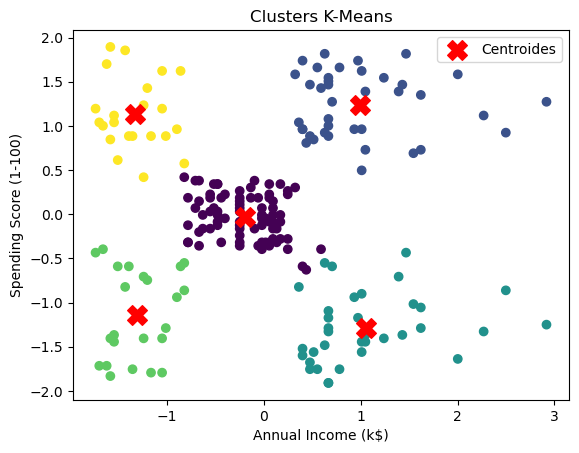


Análisis de Clústeres K-Means:
  KMeans_Cluster Annual Income (k$)            Spending Score (1-100)  \
                               mean        std                   mean   
0              0          55.296296   8.988109              49.518519   
1              1          86.538462  16.312485              82.128205   
2              2          88.200000  16.399067              17.114286   
3              3          26.304348   7.893811              20.913043   
4              4          25.727273   7.566731              79.363636   

                    Age               Gender  
         std       mean        std      mean  
0   6.530909  42.716049  16.447822  0.592593  
1   9.364489  32.692308   3.728650  0.538462  
2   9.952154  41.114286  11.341676  0.457143  
3  13.017167  45.217391  13.228607  0.608696  
4  10.504174  25.272727   5.257030  0.590909  

Interpretación de los clusters:

Clúster 0:
  - Annual Income (k$): Media = 55.30, Desviación Estándar = 8.99
  - Spending Sco

In [4]:

# K-Means (con datos escalados y k óptimo del codo)
k_optimo = 5  # Reemplaza con el valor que hayas determinado. Justifica tu elección.
kmeans = KMeans(n_clusters=k_optimo, random_state=0, n_init=10)
kmeans.fit(df_scaled)
labels = kmeans.labels_



# Evaluación
silhouette = silhouette_score(df_scaled, labels)
calinski = calinski_harabasz_score(df_scaled, labels)
davies = davies_bouldin_score(df_scaled, labels)

print(f'Silhouette Score: {silhouette}')
print(f'Calinski-Harabasz Index: {calinski}')
print(f'Davies-Bouldin Index: {davies}')

# Visualización 
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=labels) # Visualización con las características seleccionadas
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroides')
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Clusters K-Means')
plt.legend()
plt.show()



# Análisis de clusters (incluyendo interpretación)
df['KMeans_Cluster'] = labels

cluster_analysis = df.groupby('KMeans_Cluster').agg(
    {'Annual Income (k$)': ['mean', 'std'], 
     'Spending Score (1-100)': ['mean', 'std'],
     'Age': ['mean', 'std'],
     'Gender': ['mean'] # Media para obtener proporción 
    }
).reset_index()

print("\nAnálisis de Clústeres K-Means:")
print(cluster_analysis)


# Interpretación de resultados
print("\nInterpretación de los clusters:")
for i in range(k_optimo):
    print(f"\nClúster {i}:")
    
    # Variables numéricas (con media y desviación estándar)
    for feature in ['Annual Income (k$)', 'Spending Score (1-100)', 'Age']:
        mean_value = cluster_analysis.loc[i, (feature, 'mean')]
        std_value = cluster_analysis.loc[i, (feature, 'std')]
        print(f"  - {feature}: Media = {mean_value:.2f}, Desviación Estándar = {std_value:.2f}")

    # 'Gender' (solo proporción/porcentaje)
    female_percentage = cluster_analysis.loc[i, ('Gender', 'mean')] * 100
    print(f"  - Gender (Porcentaje de mujeres): {female_percentage:.2f}%") 

# Justificación de k (detallada)
print("\nJustificación de la elección de k:")
print(f"Se eligió k={k_optimo} basándonos en el método del codo, que mostraba un cambio significativo en la pendiente de la curva de inercia alrededor de ese valor.")